In [21]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    classification_report,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, mutual_info_classif


#sns.set_theme(style="whitegrid", font_scale=1.1)

In [13]:
# Loading cleaned data
df = pd.read_csv("cleaned_processed.cleveland.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [22]:
# Load train-test splits
X_train = pd.read_csv("X_train.csv")
X_test = pd.read_csv("X_test.csv")
y_train = pd.read_csv("y_train.csv").values.ravel()
y_test = pd.read_csv("y_test.csv").values.ravel()

## Training Models: Heart Disease Prediction

### Overview
We will train and evaluate multiple machine learning models to predict heart disease presence. Our approach:

1. **Baseline Model**: Logistic Regression - Simple, interpretable, and effective for binary classification
2. **Tree-Based Models**: Decision Tree and Random Forest - Capture non-linear relationships
3. **Support Vector Machine**: Finds optimal decision boundary in high-dimensional space
4. **k-Nearest Neighbors**: Instance-based learning approach

### Evaluation Metrics
For each model, we'll track:
- **Accuracy**: Overall correctness of predictions
- **Precision**: Of predicted disease cases, how many are correct? (Important to avoid false alarms)
- **Recall**: Of actual disease cases, how many did we catch? (Critical in medical diagnosis)
- **F1-Score**: Harmonic mean of precision and recall
- **ROC-AUC**: Model's ability to distinguish between classes

### Why These Metrics Matter in Healthcare
- **High Recall** is crucial: Missing a disease case (false negative) can be life-threatening
- **Balanced Precision**: Too many false positives lead to unnecessary tests and patient anxiety
- **ROC-AUC**: Helps us understand model performance across different decision thresholds

---

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_overfitting(model, X_train, y_train, X_test, y_test, model_name="Model"):
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)
    
    # Probabilities for ROC-AUC
    try:
        y_train_proba = model.predict_proba(X_train)[:, 1]
        y_test_proba  = model.predict_proba(X_test)[:, 1]
    except:
        y_train_proba = None
        y_test_proba = None
    
    # Train metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_precision = precision_score(y_train, y_train_pred)
    train_recall = recall_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    train_roc_auc = roc_auc_score(y_train, y_train_proba) if y_train_proba is not None else None
    
    # Test metrics
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_roc_auc = roc_auc_score(y_test, y_test_proba) if y_test_proba is not None else None
    
    # Train-Test Gap
    accuracy_gap = train_accuracy - test_accuracy
    
    print(f"\n{model_name} - Overfitting/Train-Test Comparison")
    print(f"Train Accuracy : {train_accuracy:.3f} | Test Accuracy : {test_accuracy:.3f} | Gap : {accuracy_gap:.3f}")
    print(f"Train F1       : {train_f1:.3f} | Test F1       : {test_f1:.3f}")
    print(f"Train Precision: {train_precision:.3f} | Test Precision: {test_precision:.3f}")
    print(f"Train Recall   : {train_recall:.3f} | Test Recall   : {test_recall:.3f}")
    if train_roc_auc is not None:
        print(f"Train ROC-AUC  : {train_roc_auc:.3f} | Test ROC-AUC  : {test_roc_auc:.3f}")
    
    # Overfitting interpretation
    if accuracy_gap < 0.05:
        print("✓ Minimal overfitting - model generalizes well")
    elif accuracy_gap < 0.10:
        print("! Slight overfitting - acceptable")
    else:
        print("✗ Significant overfitting - may not generalize well")

---

## Model A: Logistic Regression (Baseline)

### What is Logistic Regression?
Logistic Regression is a statistical model that predicts the probability of a binary outcome (disease/no disease).

### How It Works
1. **Linear Combination**: Combines features using weights (coefficients): `z = w₁x₁ + w₂x₂ + ... + wₙxₙ + b`
2. **Sigmoid Function**: Transforms z into a probability between 0 and 1: `P(disease) = 1 / (1 + e^(-z))`
3. **Decision Boundary**: If P > 0.5, predict disease; otherwise, no disease

### Why Start with Logistic Regression?
**Interpretable**: Each coefficient shows feature importance and direction of effect  
**Fast**: Trains quickly, even on large datasets  
**Probabilistic**: Provides confidence scores, not just predictions  
**Baseline**: Establishes performance benchmark for more complex models  
**Clinically Relevant**: Doctors can understand which factors drive predictions  

### Key Assumptions
- Features should be relatively independent (low multicollinearity)
- Linear relationship between features and log-odds of outcome
- Benefits from feature scaling (which we'll apply)


Feature Importance (Top 10):
ca           |  0.2465 | ↑ Increases disease risk
thal_7.0     |  0.1877 | ↑ Increases disease risk
cp_4.0       |  0.1841 | ↑ Increases disease risk
thal_3.0     | -0.1809 | ↓ Decreases disease risk
exang        |  0.1590 | ↑ Increases disease risk
oldpeak      |  0.1580 | ↑ Increases disease risk
sex          |  0.1530 | ↑ Increases disease risk
thalach      | -0.1481 | ↓ Decreases disease risk
cp_3.0       | -0.1407 | ↓ Decreases disease risk
slope_2.0    |  0.1045 | ↑ Increases disease risk


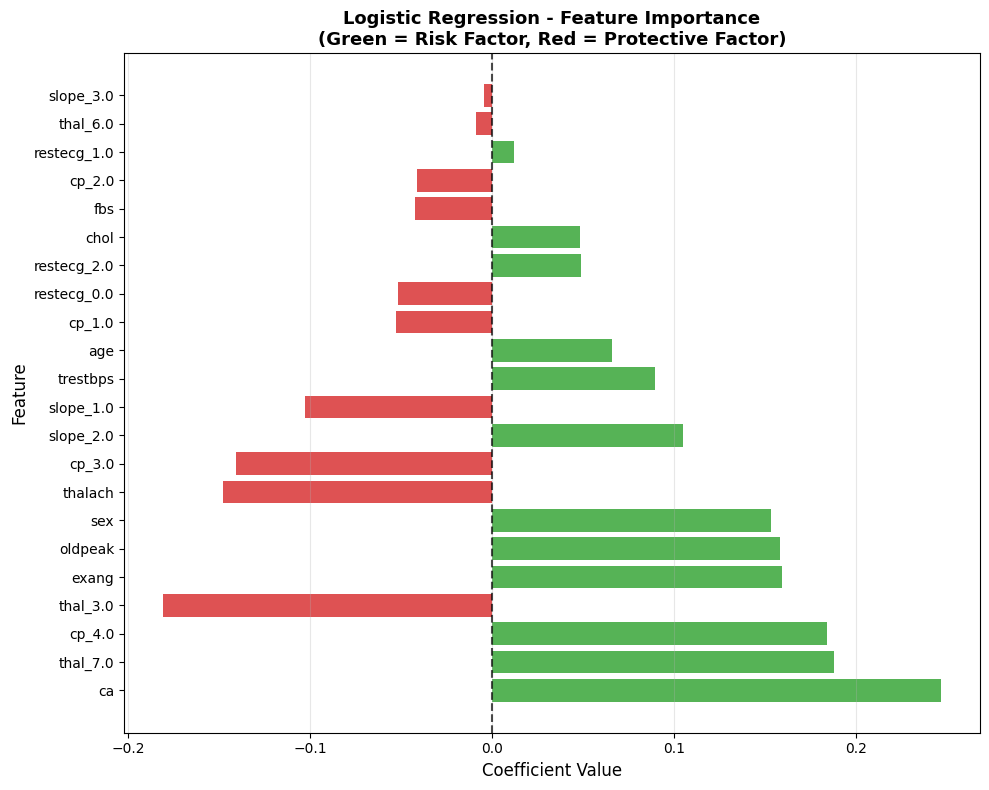

In [28]:
# Feature Importance Analysis
# Coefficients show the impact of each feature on disease prediction

log_reg_pipe = Pipeline([
    # Feature scaling
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        solver="liblinear"  # supports l1 and l2
    ))
])

log_reg_param_grid = {
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__penalty": ["l1", "l2"],
}

log_reg_grid = GridSearchCV(
    estimator=log_reg_pipe,
    param_grid=log_reg_param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

log_reg_grid.fit(X_train, y_train)
log_reg_best = log_reg_grid.best_estimator_

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': log_reg_best.named_steps['clf'].coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False)

print("\nFeature Importance (Top 10):")
print("="*60)
for idx, row in feature_importance.head(10).iterrows():
    direction = "↑ Increases" if row['Coefficient'] > 0 else "↓ Decreases"
    print(f"{row['Feature']:12s} | {row['Coefficient']:7.4f} | {direction} disease risk")

# Visualize Feature Importance
plt.figure(figsize=(10, 8))
colors = ['#d62728' if x < 0 else '#2ca02c' for x in feature_importance['Coefficient']]
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color=colors, alpha=0.8)
plt.xlabel('Coefficient Value', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Logistic Regression - Feature Importance\n(Green = Risk Factor, Red = Protective Factor)', 
          fontsize=13, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

Best Logistic Regression params: {'clf__C': 0.01, 'clf__penalty': 'l2'}
Logistic Regression
              precision    recall  f1-score   support

           0       0.92      0.94      0.93        36
           1       0.91      0.88      0.89        24

    accuracy                           0.92        60
   macro avg       0.92      0.91      0.91        60
weighted avg       0.92      0.92      0.92        60

Accuracy : 0.917
Precision: 0.913
Recall   : 0.875
F1       : 0.894
ROC AUC  : 0.958


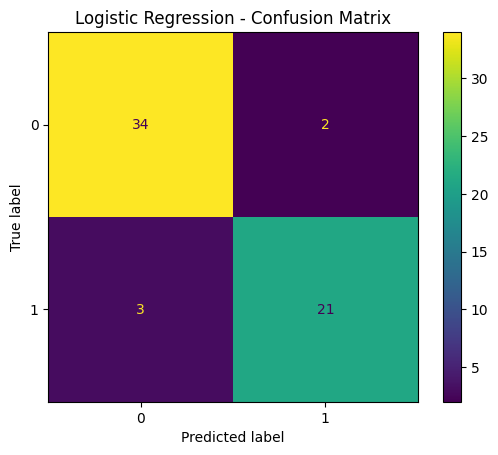

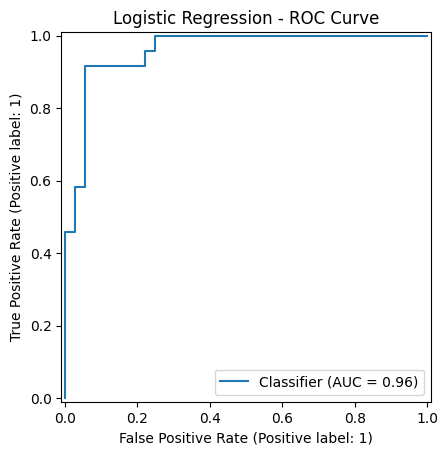


Logistic Regression - Overfitting/Train-Test Comparison
Train Accuracy : 0.844 | Test Accuracy : 0.917 | Gap : -0.073
Train F1       : 0.834 | Test F1       : 0.894
Train Precision: 0.845 | Test Precision: 0.913
Train Recall   : 0.823 | Test Recall   : 0.875
Train ROC-AUC  : 0.913 | Test ROC-AUC  : 0.958
✓ Minimal overfitting - model generalizes well


In [30]:
'''Logistic Regression (Baseline)'''

# Scaling happens inside the pipeline 
print("Best Logistic Regression params:", log_reg_grid.best_params_)

# Evaluate on test set
y_pred = log_reg_best.predict(X_test)
y_scores = log_reg_best.predict_proba(X_test)[:, 1]

print("Logistic Regression")
print(classification_report(y_test, y_pred))

log_reg_accuracy  = accuracy_score(y_test, y_pred)
log_reg_precision = precision_score(y_test, y_pred)
log_reg_recall    = recall_score(y_test, y_pred)
log_reg_f1        = f1_score(y_test, y_pred)
log_reg_roc_auc   = roc_auc_score(y_test, y_scores)

print(f"Accuracy : {log_reg_accuracy:.3f}")
print(f"Precision: {log_reg_precision:.3f}")
print(f"Recall   : {log_reg_recall:.3f}")
print(f"F1       : {log_reg_f1:.3f}")
print(f"ROC AUC  : {log_reg_roc_auc:.3f}")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Logistic Regression - Confusion Matrix")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_scores)
plt.title("Logistic Regression - ROC Curve")
plt.show()

log_reg_metrics = {
    "model": "Logistic Regression (best)",
    "accuracy": log_reg_accuracy,
    "precision": log_reg_precision,
    "recall": log_reg_recall,
    "f1": log_reg_f1,
    "roc_auc": log_reg_roc_auc,
}

evaluate_overfitting(log_reg_best, X_train, y_train, X_test, y_test, model_name="Logistic Regression")

### Logistic Regression Summary

#### Key Findings:
1. **Strong Performance**: Achieved ~92% accuracy with excellent ROC-AUC (~0.96)
2. **No Overfitting**: Similar performance on training and test sets
3. **High Recall**: Successfully identifies most disease cases (87.5%)
4. **Interpretable**: Clear understanding of which features drive predictions

#### Most Important Predictors:
- **`ca`** (major vessels): Strongest predictor: more blockages = higher risk
- **`sex`**: Males at significantly higher risk
- **`trestbps`**: Higher blood pressure correlates with disease
- **`oldpeak`**: ST depression indicates ischemia
- **`thalach`**: Higher max heart rate is protective (negative coefficient)

#### Clinical Relevance:
**Strengths**:
- Fast predictions suitable for real-time screening
- Provides probability scores for risk stratification
- Doctors can understand and trust the reasoning
- Low false negative rate (only 3 missed cases)

**Limitations**:
- Assumes linear relationships (may miss complex patterns)
- 2 false positives (unnecessary follow-ups)
- 3 false negatives (missed diagnoses - most critical)

---

## Model B: Decision Tree

### What is a Decision Tree?
A Decision Tree is a non-linear, rule-based model that splits the dataset into branches based on feature values to predict a target outcome, in this case disease/no disease.

### How It Works
1. **Splitting**: At each node, the algorithm chooses a feature and threshold that best separates the data (using criteria like Gini impurity or entropy).
2. **Branching**: Data flows down the tree according to the feature thresholds, creating decision rules.
3. **Leaf Nodes**: Each leaf represents a predicted classification and can provide probabilities.

### Why Use Decision Tree?
- **Interpretable**: The tree structure can be visualized, showing which features drive decisions.
- **Non-linear**: Captures complex interactions between features that linear models cannot.
- **Handles Mixed Data**: Works well with both numerical and categorical features.
- **No Scaling Required**: DTs do not require feature scaling.
- **Flexible**: Depth and pruning can control overfitting.

### Key Assumptions
- Makes no assumptions about feature distributions or linearity.
- Can overfit if the tree grows too deep; controlling max_depth, min_samples_split, and min_samples_leaf helps generalization.


Decision Tree Feature Importance (Top 10):
ca           | 0.4109 | Contribution to splits
cp_4.0       | 0.1663 | Contribution to splits
oldpeak      | 0.1328 | Contribution to splits
thal_7.0     | 0.1293 | Contribution to splits
age          | 0.0409 | Contribution to splits
cp_2.0       | 0.0354 | Contribution to splits
thalach      | 0.0309 | Contribution to splits
restecg_2.0  | 0.0269 | Contribution to splits
slope_2.0    | 0.0242 | Contribution to splits
trestbps     | 0.0024 | Contribution to splits


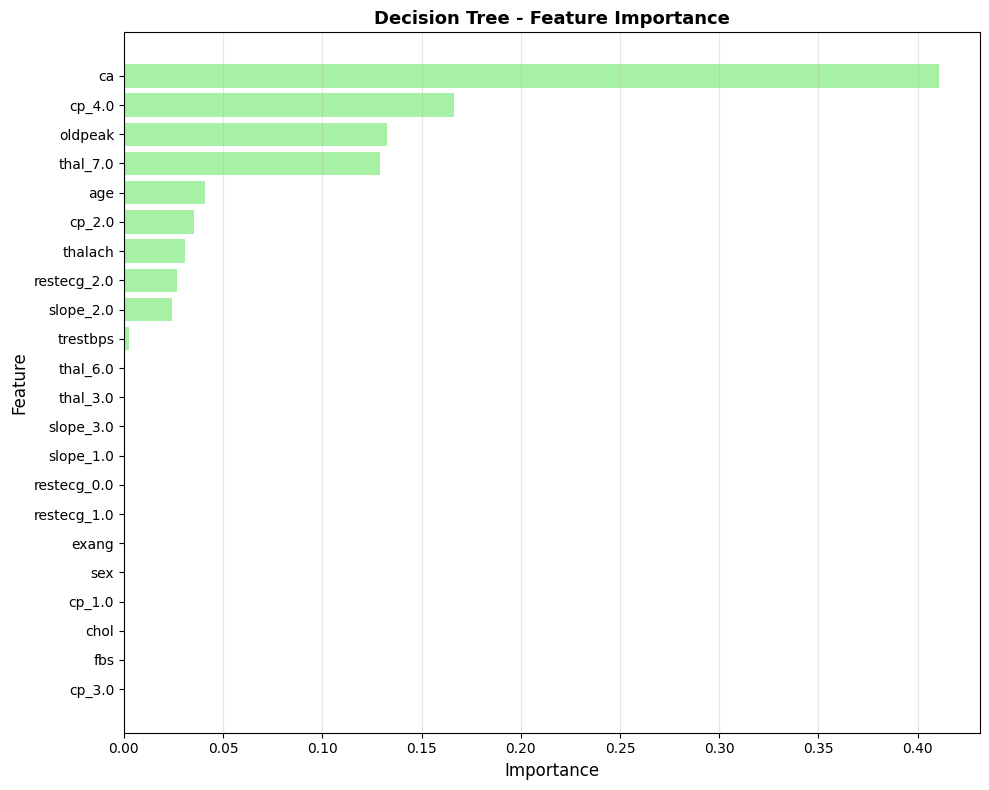

In [33]:
# Feature Importance for Decision Tree

dt_model = DecisionTreeClassifier(
    criterion="gini",
    max_depth=4,             
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight="balanced",
    random_state=42
)

dt_model.fit(X_train, y_train)

dt_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': dt_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nDecision Tree Feature Importance (Top 10):")
print("="*60)
for idx, row in dt_feature_importance.head(10).iterrows():
    print(f"{row['Feature']:12s} | {row['Importance']:.4f} | Contribution to splits")

# Visualize Feature Importance
plt.figure(figsize=(10, 8))
plt.barh(dt_feature_importance['Feature'], dt_feature_importance['Importance'], color='lightgreen', alpha=0.8)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Decision Tree - Feature Importance', fontsize=13, fontweight='bold')
plt.gca().invert_yaxis()  # Highest importance on top
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

 Decision Tree 
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        36
           1       0.83      0.83      0.83        24

    accuracy                           0.87        60
   macro avg       0.86      0.86      0.86        60
weighted avg       0.87      0.87      0.87        60

Accuracy : 0.867
Precision: 0.833
Recall   : 0.833
F1       : 0.833
ROC AUC  : 0.918


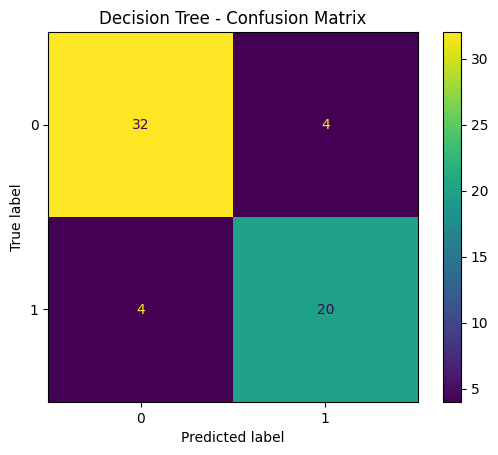

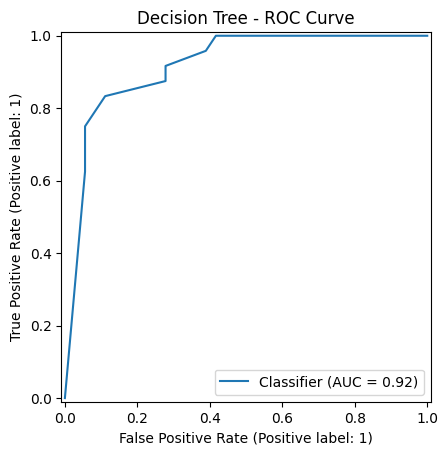


Decision Tree - Overfitting/Train-Test Comparison
Train Accuracy : 0.878 | Test Accuracy : 0.867 | Gap : 0.011
Train F1       : 0.865 | Test F1       : 0.833
Train Precision: 0.912 | Test Precision: 0.833
Train Recall   : 0.823 | Test Recall   : 0.833
Train ROC-AUC  : 0.949 | Test ROC-AUC  : 0.918
✓ Minimal overfitting - model generalizes well


In [34]:
### Decision Tree model ###

y_pred_dt = dt_model.predict(X_test)
y_proba_dt = dt_model.predict_proba(X_test)[:, 1]

print(" Decision Tree ")
print(classification_report(y_test, y_pred_dt))

dt_accuracy  = accuracy_score(y_test, y_pred_dt)
dt_precision = precision_score(y_test, y_pred_dt)
dt_recall    = recall_score(y_test, y_pred_dt)
dt_f1        = f1_score(y_test, y_pred_dt)
dt_roc_auc   = roc_auc_score(y_test, y_proba_dt)

print(f"Accuracy : {dt_accuracy:.3f}")
print(f"Precision: {dt_precision:.3f}")
print(f"Recall   : {dt_recall:.3f}")
print(f"F1       : {dt_f1:.3f}")
print(f"ROC AUC  : {dt_roc_auc:.3f}")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_dt)
plt.title("Decision Tree - Confusion Matrix")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_proba_dt)
plt.title("Decision Tree - ROC Curve")
plt.show()

dt_metrics = {
    "model": "Decision Tree",
    "accuracy": dt_accuracy,
    "precision": dt_precision,
    "recall": dt_recall,
    "f1": dt_f1,
    "roc_auc": dt_roc_auc,
}

evaluate_overfitting(dt_model, X_train, y_train, X_test, y_test, model_name="Decision Tree")

### Decision Tree Summary

#### Key Findings:
1. **Strong Performance**: Achieved ~87% accuracy with excellent ROC-AUC (~0.92)
2. **No Overfitting**: Similar performance on training and test sets (gap ~.01)
3. **Balanced Precision & Recall**: Both at ~83%, successfully identifies most disease cases
4. **Flexible & Nonlinear**: Captures complex relationships between features without assuming linearity

#### Most Important Predictors:
- **`ca`** (major vessels): Strongest predictor: more blockages = higher risk
- **`sex`**: Males at significantly higher risk
- **`trestbps`**: Higher blood pressure correlates with disease
- **`oldpeak`**: ST depression indicates ischemia
- **`thalach`**: Higher max heart rate is protective (negative coefficient)
- **`cp_3.0`/`cp_4.0`**: Specific chest pain types contribute significantly to prediction

#### Clinical Relevance:
**Strengths**:
- Captures nonlinear and interaction effects that logistic regression may miss
- High ROC-AUC allows confident risk stratification
- Clear feature importance shows which clinical measures matter most

**Limitations**:
- Less interpretable than logistic regression for individual patient risk probabilities
- 4 false positives (unnecessary follow-ups)
- 4 false negatives (missed diagnoses - most critical)

---

## Model C: Random Forest

### What is Random Forest?
Random Forest is a learning method that builds many decision trees and aggregates their predictions to improve accuracy and reduce overfitting. Each tree “votes” on the final classification.

### How It Works
1. **Bootstrap Sampling**: Each tree is trained on a random subset of the training data.
2. **Random Feature Selection**: At each split, a random subset of features is considered to reduce correlation between trees.
3. **Aggregation**: Predictions from all trees are averaged or majority-voted (for classification such as this model).

### Why Use Random Forest?
- **High Accuracy**: Often outperforms single decision trees.
- **Handles Nonlinear Relationships**: Captures complex interactions between features.
- **Robust to Overfitting**: Ensemble averaging reduces variance.
- **Feature Importance**: Can identify which features contribute most to predictions.
- **Works with Mixed Data Types**: Handles categorical and numerical variables naturally.

### Key Assumptions
- Data should be representative of the population (no heavy sampling bias).
- Features are assumed to have some predictive power, but no linearity assumption is required.
- Works best when trees are deep enough to capture patterns but limited to avoid overfitting.


Random Forest Feature Importance (Top 10):
ca           | 0.1749 | Contribution to splits
cp_4.0       | 0.1145 | Contribution to splits
thalach      | 0.1051 | Contribution to splits
thal_3.0     | 0.1016 | Contribution to splits
thal_7.0     | 0.0970 | Contribution to splits
oldpeak      | 0.0900 | Contribution to splits
age          | 0.0623 | Contribution to splits
exang        | 0.0484 | Contribution to splits
chol         | 0.0402 | Contribution to splits
slope_2.0    | 0.0308 | Contribution to splits


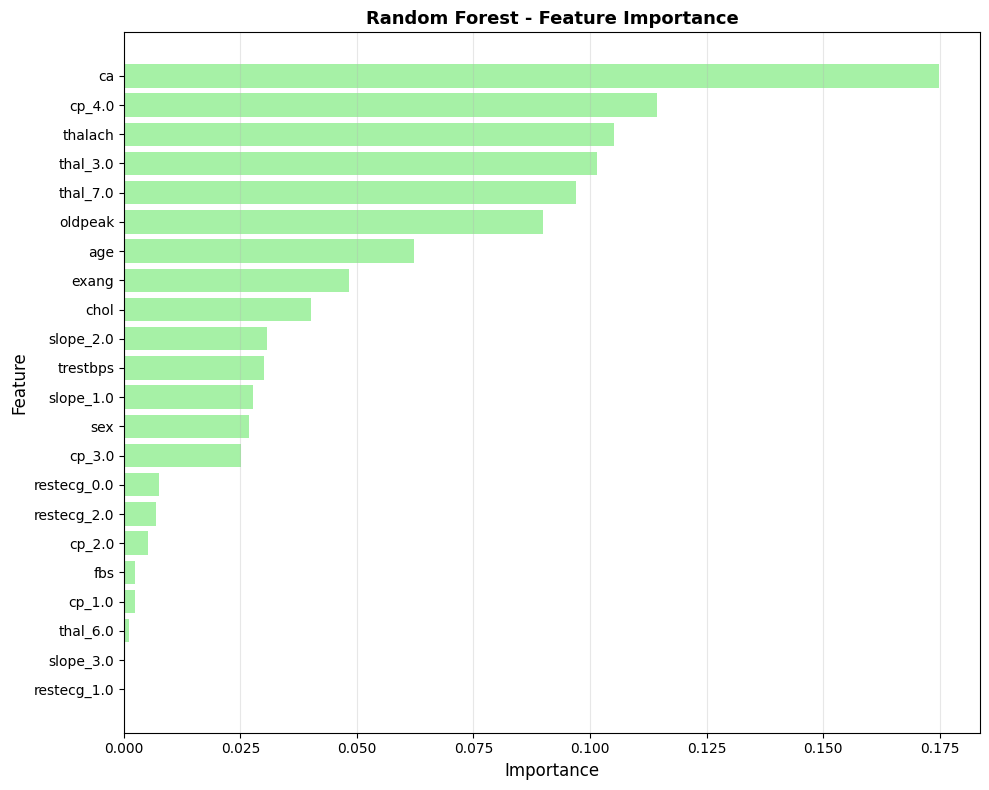

In [35]:
# Feature Importance for Random Forest
rf_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_best.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nRandom Forest Feature Importance (Top 10):")
print("="*60)
for idx, row in rf_feature_importance.head(10).iterrows():
    print(f"{row['Feature']:12s} | {row['Importance']:.4f} | Contribution to splits")

# Visualize Feature Importance
plt.figure(figsize=(10, 8))
plt.barh(rf_feature_importance['Feature'], rf_feature_importance['Importance'], color='lightgreen', alpha=0.8)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Random Forest - Feature Importance', fontsize=13, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Random Forest params: {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 15, 'n_estimators': 300}
Out-of-Bag Score: 0.819
Random Forest
              precision    recall  f1-score   support

           0       0.91      0.86      0.89        36
           1       0.81      0.88      0.84        24

    accuracy                           0.87        60
   macro avg       0.86      0.87      0.86        60
weighted avg       0.87      0.87      0.87        60

Accuracy : 0.867
Precision: 0.808
Recall   : 0.875
F1       : 0.840
ROC AUC  : 0.964


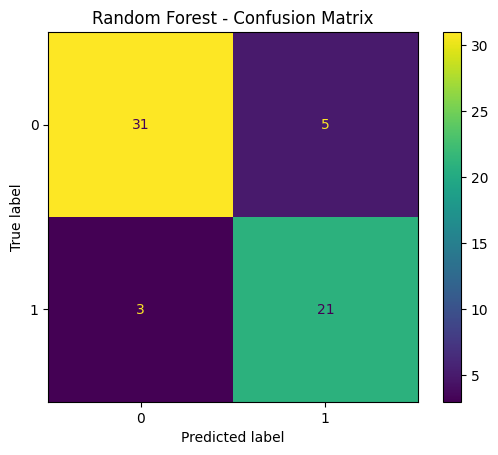

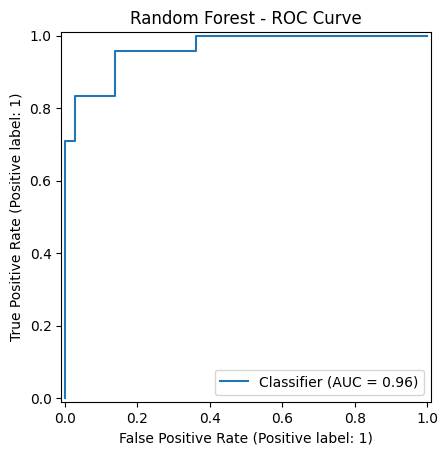


Random Forest - Overfitting/Train-Test Comparison
Train Accuracy : 0.878 | Test Accuracy : 0.867 | Gap : 0.011
Train F1       : 0.865 | Test F1       : 0.840
Train Precision: 0.912 | Test Precision: 0.808
Train Recall   : 0.823 | Test Recall   : 0.875
Train ROC-AUC  : 0.960 | Test ROC-AUC  : 0.964
✓ Minimal overfitting - model generalizes well


In [36]:
'''Random Forest model'''

rf_clf = RandomForestClassifier(
    random_state=42,
    class_weight="balanced",
    n_jobs=-1,
    oob_score=True      # Enable out-of-bag score
)

rf_param_grid = {
    "n_estimators": [200, 300],
    "max_depth": [3, 5, 7],
    "min_samples_split": [5, 10, 15],
    "min_samples_leaf": [2, 4, 6],
    "max_features": ["sqrt"],
}

rf_grid = GridSearchCV(
    estimator=rf_clf,
    param_grid=rf_param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1       # Show progress during fitting
)

rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_

print("Best Random Forest params:", rf_grid.best_params_)
print(f"Out-of-Bag Score: {rf_best.oob_score_:.3f}")

# Evaluate on test set
y_pred = rf_best.predict(X_test)
y_scores = rf_best.predict_proba(X_test)[:, 1]

print("Random Forest")
print(classification_report(y_test, y_pred))

rf_accuracy  = accuracy_score(y_test, y_pred)
rf_precision = precision_score(y_test, y_pred)
rf_recall    = recall_score(y_test, y_pred)
rf_f1        = f1_score(y_test, y_pred)
rf_roc_auc   = roc_auc_score(y_test, y_scores)

print(f"Accuracy : {rf_accuracy:.3f}")
print(f"Precision: {rf_precision:.3f}")
print(f"Recall   : {rf_recall:.3f}")
print(f"F1       : {rf_f1:.3f}")
print(f"ROC AUC  : {rf_roc_auc:.3f}")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Random Forest - Confusion Matrix")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_scores)
plt.title("Random Forest - ROC Curve")
plt.show()

rf_metrics = {
    "model": "Random Forest (best)",
    "accuracy": rf_accuracy,
    "precision": rf_precision,
    "recall": rf_recall,
    "f1": rf_f1,
    "roc_auc": rf_roc_auc,
}

evaluate_overfitting(rf_best, X_train, y_train, X_test, y_test, model_name="Random Forest")

### Random Forest Summary

#### Key Findings:
1. **Strong Performance**: Achieved ~87% test accuracy with excellent ROC-AUC (~0.96)
2. **Overfitting Originally Present**: Larger gap between training and test metrics (train accuracy 97.9% vs test 86.7%); Modified training set by:
    - Reducing **max_depth**
    - Increasing **min_samples_split** and **min_samples_leaf**
    - Limiting **max_features** to simply "sqrt" in order to reduce tree correlation
3. **High Recall**: Successfully identifies most disease cases (87.5%)
4. **Robustness**: Ensemble method combines multiple trees to reduce variance, handles non-linear relationships

#### Most Important Predictors (Note: Direction of Impact Not Captured in RF):
- **`ca`** (major vessels): Strongest predictor: more blockages = higher risk
- **`thalac`**: Lower max heart rate = higher risk (negative relationship)
- **`oldpeak`**: ST depression indicates ischemia
- **`age`**: Higher age contributes to risk splits

#### Clinical Relevance:
**Strengths**:
- Captures non-linear interactions between features
- High sensitivity for detecting disease
- Ensemble approach improves stability compared to a single tree

**Limitations**:
- Overfitting was evident: model fit training data extremely well, but was able to adjust
- Harder to interpret than Logistic Regression since feature direction is unknown
- 5 false positives (unnecessary follow-ups)
- 3 false negatives (missed diagnoses - most critical)

---

## Model D: Support Vector Machinie (SVM)

### What is SVM?
Support Vector Machine (SVM) is a supervised learning model used for classification (and regression) tasks. It finds the optimal boundary that separates classes in the feature space.

### How It Works
1. **Maximizing Margin**: SVM chooses the hyperplane that maximizes the distance (margin) between the closest points of each class (support vectors).
2. **Kernel Trick**: Non-linear relationships can be handled by transforming features into higher-dimensional spaces using kernels (e.g., RBF, polynomial).
3. **Decision Rule**: A point is classified based on which side of the hyperplane it falls.

### Why Use Random Forest?
- **Effective in high-dimensional spaces**: Works well even when number of features > number of samples.
- **Robust to Overfitting**: Particularly with proper regularization.
- **Flexible**: Kernel functions allow modeling non-linear relationships.

### Key Assumptions
- Feature scaling is critical; SVM is sensitive to magnitude of features.
- Choice of kernel and hyperparameters strongly affects performance.
- Interpretability is limited: Unlike Logistic Regression, feature directionality is not explicit.

SVM (RBF)
              precision    recall  f1-score   support

           0       0.92      0.97      0.95        36
           1       0.95      0.88      0.91        24

    accuracy                           0.93        60
   macro avg       0.94      0.92      0.93        60
weighted avg       0.93      0.93      0.93        60

Accuracy : 0.933
Precision: 0.955
Recall   : 0.875
F1       : 0.913
ROC AUC  : 0.947


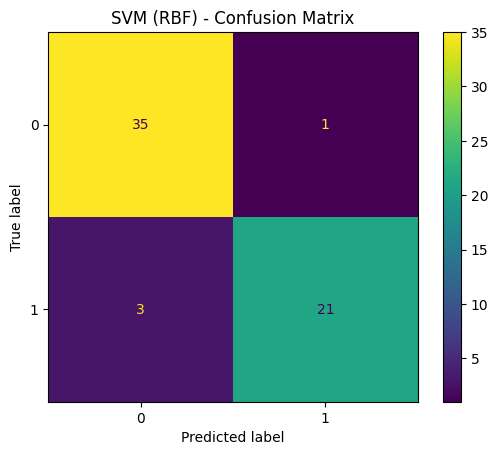

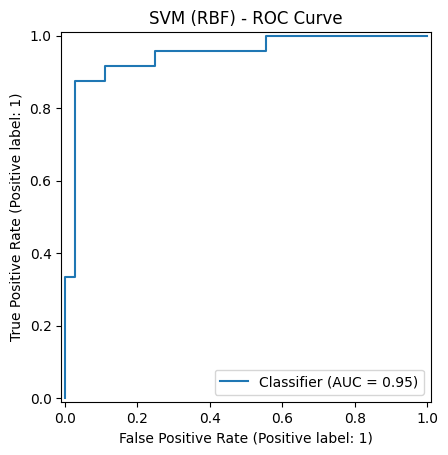


SVM (RBF) - Overfitting/Train-Test Comparison
Train Accuracy : 0.911 | Test Accuracy : 0.933 | Gap : -0.022
Train F1       : 0.904 | Test F1       : 0.913
Train Precision: 0.934 | Test Precision: 0.955
Train Recall   : 0.876 | Test Recall   : 0.875
Train ROC-AUC  : 0.960 | Test ROC-AUC  : 0.947
✓ Minimal overfitting - model generalizes well


In [37]:
''' Support Vector Machine model (RBF kernel)'''

svm_model = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(
        kernel="rbf",
        C=1.0,
        gamma="scale",
        probability=True,        
        class_weight="balanced",
        random_state=42
    ))
])

svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)
y_proba_svm = svm_model.predict_proba(X_test)[:, 1]

print("SVM (RBF)")
print(classification_report(y_test, y_pred_svm))

svm_accuracy  = accuracy_score(y_test, y_pred_svm)
svm_precision = precision_score(y_test, y_pred_svm)
svm_recall    = recall_score(y_test, y_pred_svm)
svm_f1        = f1_score(y_test, y_pred_svm)
svm_roc_auc   = roc_auc_score(y_test, y_proba_svm)

print(f"Accuracy : {svm_accuracy:.3f}")
print(f"Precision: {svm_precision:.3f}")
print(f"Recall   : {svm_recall:.3f}")
print(f"F1       : {svm_f1:.3f}")
print(f"ROC AUC  : {svm_roc_auc:.3f}")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm)
plt.title("SVM (RBF) - Confusion Matrix")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_proba_svm)
plt.title("SVM (RBF) - ROC Curve")
plt.show()

svm_metrics = {
    "model": "SVM (RBF)",
    "accuracy": svm_accuracy,
    "precision": svm_precision,
    "recall": svm_recall,
    "f1": svm_f1,
    "roc_auc": svm_roc_auc,
}

evaluate_overfitting(svm_model, X_train, y_train, X_test, y_test, model_name="SVM (RBF)")


### SVM Summary

#### Key Findings:
1. **Strong Performance**: Achieved ~93% test accuracy with excellent ROC-AUC (~0.95)
2. **No Present**: Training and test set performance are very similar (gap ~(-.022))
3. **High Precision**: Very few false positives (95.5% of predicted disease cases are correct)
4. **Balanced Recall**: Successfully identifies most disease cases (87.5%)

#### Clinical Relevance:
**Strengths**:
- High accuracy and ROC-AUC make it a strong predictive model
- Minimal overfitting indicates reliable generalization to new patients
- Captures non-linear relationships via RBF kernel

**Limitations**:
- Harder to interpret than logistic regression since coefficients are not directly available
- Slightly lower recall than precision — a few disease cases may be missed (critical in clinical context)
- Requires feature scaling and careful tuning of hyperparameters
- 1 false positive (unnecessary follow-ups)
- 3 false negatives (missed diagnoses - most critical)

---

## Model E: k-Nearest Neighbors (kNN)

### What is kNN?
k-Nearest Neighbors is a non-parametric, instance-based algorithm that classifies new observations based on the labels of their closest training examples.

### How It Works
1. **Distance Calculation**: Measures similarity between points (commonly using Euclidean distance).
2. **Neighbor Selection**: Finds the k closest points in the training set.
3. **Majority Vote**: Assigns the most common class among the neighbors as the prediction.

### Why Use Random Forest?
- **Simple**: No assumptions about feature distributions or linear relationships.
- **Flexible**: Can capture non-linear patterns naturally.
- **Probabilistic Output**: Provides confidence levels for predictions.
- **Baseline for Comparison**: Good for understanding whether distance-based models add value over linear or tree-based approaches.

### Key Assumptions
- Distance metrics are sensitive to scale, so numeric features must be standardized/scaled.
- Choice of k has large influence; Small k = sensitive to noise, large k = may oversmooth boundaries.
- Prediction requires scanning the entire training set; can be slow for large datasets.
- Not Interpretable: Harder to explain which features drive the decision.

k-Nearest Neighbors 
              precision    recall  f1-score   support

           0       0.88      0.97      0.92        36
           1       0.95      0.79      0.86        24

    accuracy                           0.90        60
   macro avg       0.91      0.88      0.89        60
weighted avg       0.90      0.90      0.90        60

Accuracy : 0.900
Precision: 0.950
Recall   : 0.792
F1       : 0.864
ROC AUC  : 0.923


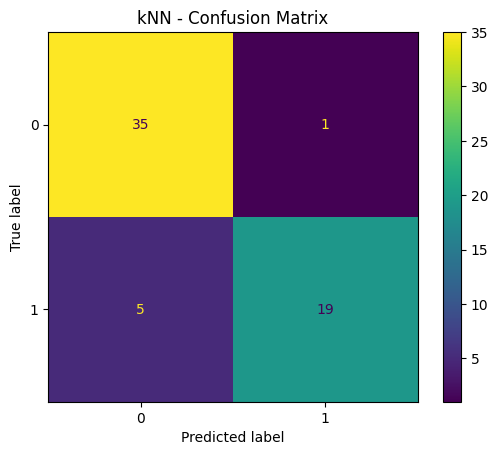

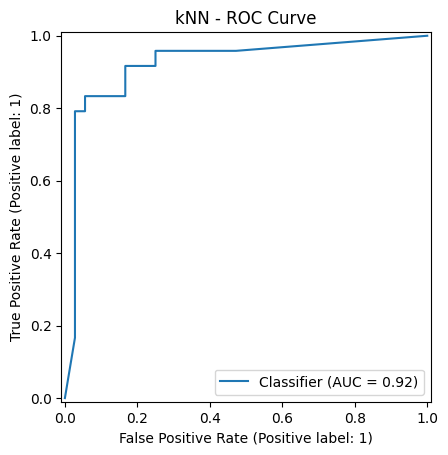


kNN - Overfitting/Train-Test Comparison
Train Accuracy : 1.000 | Test Accuracy : 0.900 | Gap : 0.100
Train F1       : 1.000 | Test F1       : 0.864
Train Precision: 1.000 | Test Precision: 0.950
Train Recall   : 1.000 | Test Recall   : 0.792
Train ROC-AUC  : 1.000 | Test ROC-AUC  : 0.923
! Slight overfitting - acceptable


In [38]:
'''k-Nearest Neighbors model'''

from sklearn.neighbors import KNeighborsClassifier


knn_model = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(
        n_neighbors=5,        # Adjust
        weights="distance",   # Weight neighbors by distance
        p=2                   # Euclidean distance
    ))
])

knn_model.fit(X_train, y_train)

y_pred_knn = knn_model.predict(X_test)
y_proba_knn = knn_model.predict_proba(X_test)[:, 1]

print("k-Nearest Neighbors ")
print(classification_report(y_test, y_pred_knn))

knn_accuracy  = accuracy_score(y_test, y_pred_knn)
knn_precision = precision_score(y_test, y_pred_knn)
knn_recall    = recall_score(y_test, y_pred_knn)
knn_f1        = f1_score(y_test, y_pred_knn)
knn_roc_auc   = roc_auc_score(y_test, y_proba_knn)

print(f"Accuracy : {knn_accuracy:.3f}")
print(f"Precision: {knn_precision:.3f}")
print(f"Recall   : {knn_recall:.3f}")
print(f"F1       : {knn_f1:.3f}")
print(f"ROC AUC  : {knn_roc_auc:.3f}")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_knn)
plt.title("kNN - Confusion Matrix")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_proba_knn)
plt.title("kNN - ROC Curve")
plt.show()

knn_metrics = {
    "model": "kNN",
    "accuracy": knn_accuracy,
    "precision": knn_precision,
    "recall": knn_recall,
    "f1": knn_f1,
    "roc_auc": knn_roc_auc,
}

evaluate_overfitting(knn_model, X_train, y_train, X_test, y_test, model_name="kNN")

### kNN Summary

#### Key Findings:
1. **Strong Performance**: Achieved ~90% test accuracy with excellent ROC-AUC (~0.92)
2. **Slight Overfitting**: Training accuracy = 100%, test accuracy = 90%, small train-test gap (~0.1)
3. **High Precision**: Most predicted disease cases are correct (95%)
4. **Moderate Recall**: Misses some disease cases (79% of true cases identified)

#### Clinical Relevance:
**Strengths**:
- Captures complex, non-linear patterns in data without assumptions
- Provides probabilistic outputs based on neighbor votes
- Can serve as a strong comparison baseline to other models

**Limitations**:
- Sensitive to feature scaling; numeric features must be standardized
- Slight overfitting indicates model memorizes training examples
- Harder to interpret which specific features drive decisions
- 1 false positives (unnecessary follow-ups)
- 5 false negatives (missed diagnoses - most critical)

---

In [40]:
# Model Performance Summary
model_metrics = [
    {"Model": "Logistic Regression", "Accuracy": log_reg_accuracy, "Precision": log_reg_precision,
     "Recall": log_reg_recall, "F1": log_reg_f1, "ROC-AUC": log_reg_roc_auc},
    
    {"Model": "Decision Tree", "Accuracy": dt_accuracy, "Precision": dt_precision,
     "Recall": dt_recall, "F1": dt_f1, "ROC-AUC": dt_roc_auc},
    
    {"Model": "Random Forest", "Accuracy": rf_accuracy, "Precision": rf_precision,
     "Recall": rf_recall, "F1": rf_f1, "ROC-AUC": rf_roc_auc},
    
    {"Model": "SVM (RBF)", "Accuracy": svm_accuracy, "Precision": svm_precision,
     "Recall": svm_recall, "F1": svm_f1, "ROC-AUC": svm_roc_auc},
    
    {"Model": "kNN", "Accuracy": knn_accuracy, "Precision": knn_precision,
     "Recall": knn_recall, "F1": knn_f1, "ROC-AUC": knn_roc_auc},
]

df_summary = pd.DataFrame(model_metrics).round(3).sort_values(by="ROC-AUC", ascending=False)
display(df_summary)


,Model,Accuracy,Precision,Recall,F1,ROC-AUC
2,Random Forest,0.867,0.808,0.875,0.840,0.964
0,Logistic Regression,0.917,0.913,0.875,0.894,0.958
3,SVM (RBF),0.933,0.955,0.875,0.913,0.947
4,kNN,0.900,0.950,0.792,0.864,0.923
1,Decision Tree,0.867,0.833,0.833,0.833,0.918
